In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
## Load dataset
data_path = "../gmm_dataset_c20k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32

BATCH_SIZE = 20
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'baseline-mlp-%dsamples' % (SAMPLE_SIZE)
DEVICE = torch.device('cuda:0')

Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (N, K, D)

In [3]:
from local_enc import *
from global_oneshot import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    enc_z.cuda().to(DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    oneshot_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_eta, enc_z)

enc_z.load_state_dict(torch.load("../weights/enc-z-%s" % PATH))
oneshot_eta.load_state_dict(torch.load("../weights/oneshot-eta-%s" % PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
from os_ep import *
train_baseline(models, EP, optimizer, Data, Model_Params, Train_Params)

epoch: 0\200 (7s),  eubo: -361.351,  elbo: -414.994,  ess: 1.095
epoch: 1\200 (7s),  eubo: -358.888,  elbo: -413.869,  ess: 1.117
epoch: 2\200 (7s),  eubo: -362.031,  elbo: -416.458,  ess: 1.111
epoch: 3\200 (7s),  eubo: -355.952,  elbo: -412.365,  ess: 1.109
epoch: 4\200 (7s),  eubo: -358.847,  elbo: -411.874,  ess: 1.118
epoch: 5\200 (7s),  eubo: -362.755,  elbo: -418.399,  ess: 1.122
epoch: 6\200 (7s),  eubo: -359.019,  elbo: -413.974,  ess: 1.106
epoch: 7\200 (7s),  eubo: -358.944,  elbo: -411.887,  ess: 1.102
epoch: 8\200 (7s),  eubo: -360.601,  elbo: -414.569,  ess: 1.122
epoch: 9\200 (7s),  eubo: -359.719,  elbo: -414.547,  ess: 1.101
epoch: 10\200 (7s),  eubo: -357.311,  elbo: -412.688,  ess: 1.107
epoch: 11\200 (7s),  eubo: -359.067,  elbo: -411.499,  ess: 1.116
epoch: 12\200 (7s),  eubo: -359.415,  elbo: -412.948,  ess: 1.115
epoch: 13\200 (7s),  eubo: -359.623,  elbo: -415.345,  ess: 1.105
epoch: 14\200 (7s),  eubo: -357.952,  elbo: -410.300,  ess: 1.117
epoch: 15\200 (7s), 

In [8]:
# torch.save(enc_z.state_dict(), '../weights/enc-z-%s' + PATH)
# torch.save(oneshot_eta.state_dict(), '../weights/oneshot-eta-%s' + PATH)

In [13]:
def test(models, objective, Data, Model_Params, Train_Params):
    (NUM_EPOCHS, NUM_DATASETS, S, B, CUDA, device, path) = Train_Params
    SubTrain_Params = (device, S, B) + Model_Params
    ##(N, K, D, mcmc_size) = Model_Params
#     indices = torch.randperm(NUM_DATASETS)
    step = 2
    indices = torch.arange(NUM_DATASETS)
    batch_indices = indices[0*B : (0+1)*B]
    obs = Data[batch_indices]
    obs = shuffler(obs).repeat(S, 1, 1, 1)
    if CUDA:
        obs =obs.cuda().to(device)
    loss, metric_step, reused = objective(models, obs, SubTrain_Params)
    return obs, metric_step, reused

In [14]:
BATCH_SIZE_TEST = 50
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)
obs, metric_step, reused = test(models, EP, Data, Model_Params, Train_Params_Test)
(q_eta, _, q_z, _, _, _) = reused

# def plot_samples(obs, q_eta, q_z, PATH):
#     colors = ['r', 'b', 'g']
#     fig = plt.figure(figsize=(25,50))
#     xs = obs[0].cpu().data.numpy()
#     E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
#     batch_size, N, K = E_z.shape
#     _, _, D = xs.shape
#     E_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
#     E_tau = (q_eta['precisions'].dist.concentration[0] / q_eta['precisions'].dist.rate[0]).cpu().data.numpy()
#     for b in range(batch_size):
#         ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
#         xb = xs[b]
#         zb = E_z[b]
#         mu = E_mu[b].reshape(K, D)
#         sigma2 = 1. / E_tau[b]
#         assignments = zb.argmax(-1)
#         for k in range(K):
#             cov_k = np.diag(sigma2[k])
#             xk = xb[np.where(assignments == k)]
#             ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
#             plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
#         ax.set_ylim([-15, 15])
#         ax.set_xlim([-15, 15])
#     plt.savefig('../results/modes-' + PATH + '.svg')

CPU times: user 1.78 s, sys: 11.9 ms, total: 1.79 s
Wall time: 1.79 s


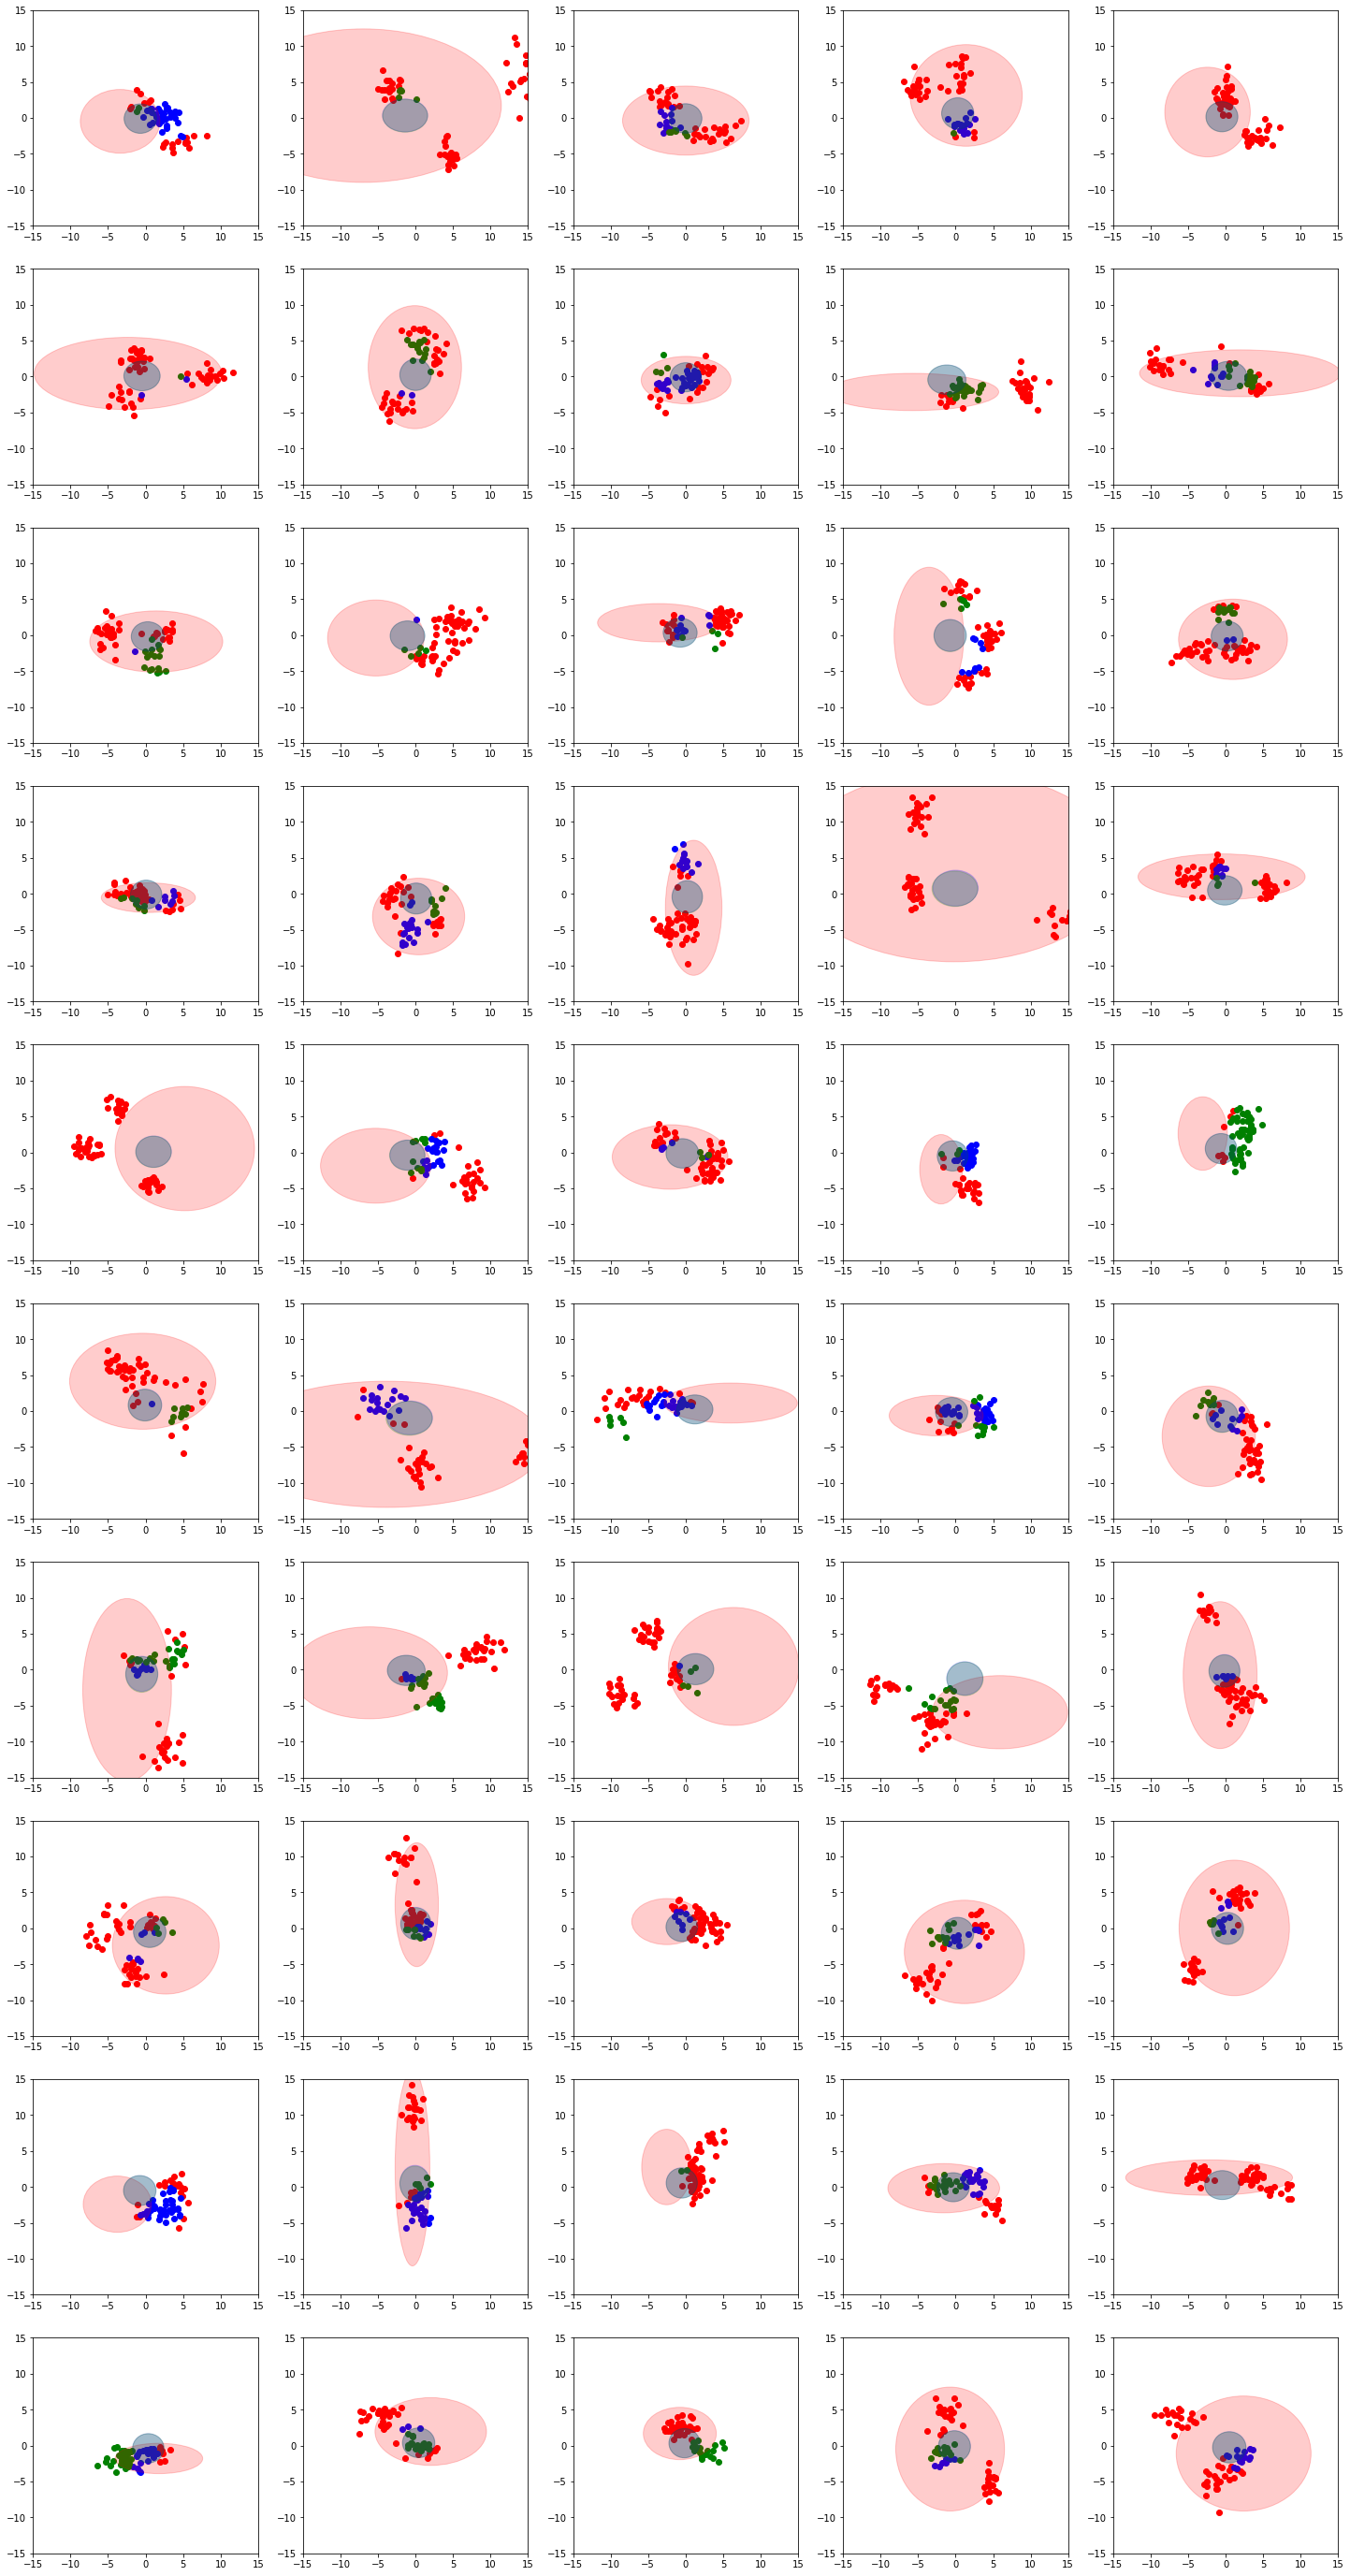

In [15]:
%time plot_samples(obs, q_eta, q_z, PATH)

In [ ]:
incremental_gap = symkl_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')

In [ ]:
incremental_gap